In this notebook, we show some examples of how to use the benchmark.
You can also start trying the benchmark by just running `python scipts/ph_optimization.py`, 
which will run the benchmark with the default parameters.

First of all, we need to add paths of the benchmarks.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
sys.path.append("../scripts")

## Table of Contents
1. [How to specify the data](##How-to-specify-the-data)
2. [How to specify the persistent-based loss](##How-to-specify-the-persistent-based-loss)
3. [How to specify the regularization](##How-to-specify-the-optimization-algorithm)
4. [How to use the optimization algorithms](##How-to-use-the-optimization-algorithms)
5. [How to use `scripts/ph_optimization.py`](##How-to-use-scripts/ph_optimization.py)

## How to specify the data

First, let us generate the point cloud to be optimized.
For convenience in later chapters, here, we define a function to generate the 1000 point cloud.

usetex mode requires dvipng.


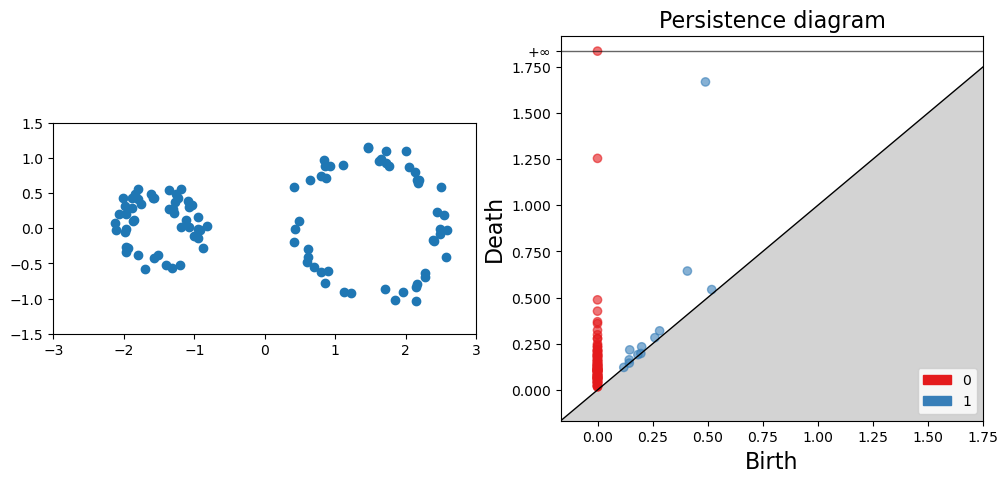

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import plot_persistence_diagram
from gudhi.rips_complex import RipsComplex

def large_hole_and_small_hole(num_pts: int) -> np.ndarray:
    small_num_pts, large_num_pts = num_pts//2, num_pts - num_pts//2
    X_list = []
    for k in range(1000):
        theta = np.random.rand(small_num_pts) * 2 * np.pi
        small = np.array([-1.5 + 0.5 * np.cos(theta), 0.5 * np.sin(theta)]).T
        theta = np.random.rand(large_num_pts) * 2 * np.pi
        large = np.array([+1.5 + 1.0 * np.cos(theta), 1.0 * np.sin(theta)]).T
        X = np.concatenate([small, large], axis=0)
        X_list.append(X)
    data = np.stack(X_list, axis=0) + np.random.randn(1000, num_pts, 2) * 0.1
    return data

data = large_hole_and_small_hole(100)
fig = plt.figure(figsize=(12, 5))
# plot the point cloud
ax = fig.add_subplot(1, 2, 1)
ax.set_xlim(-3, 3); ax.set_ylim(-1.5, 1.5); ax.set_aspect('equal')
ax.scatter(data[0, :, 0], data[0, :, 1])
# plot the persistence diagram
ax = fig.add_subplot(1, 2, 2)
rips = RipsComplex(points=data[0, :, :])
dgms = rips.create_simplex_tree(max_dimension=2).persistence()
plot_persistence_diagram(dgms, legend=True, axes=ax)

plt.show()

## How to specify the persistent-based loss

Next, we describe the way to design the persistent-based loss.
When implementing the class that represents the loss, we need to be careful about the following points:
- The class should inherit the `PersistenceBasedLoss` class in `scripts/persistence_based_loss.py`.
- We have to implement the `__call__` method, which takes a point cloud and `RipsPH` object as input and returns the loss value.
Moreover, the class need to have `get_rph` decorator.
- We have to implement the `get_direction` method. In this method, 

`RipsPH` is the class define in `scripts/lib/ph_computation_libirary.py`.
The object of `RipsPH` class has the information of the persistent homology of the point cloud.
Basically, the following two methods can be used to implement the loss function:
- `get_barcode`: obtain barcode with the format of list, np.ndarray or torch.Tensor.
- `get_differentiable_barcode`: obtain barcode with the format of differentiable torch.Tensor.
- `get_bar_object_list`: obtain barcode as a list of `Bar` objects. Please refer to `scripts/lib/ph_compute_library.py` for the definition of `Bar` class.

Now, we define our own loss function.
We use wasserstein distance as the loss function here.
The desirable direction for each point in PD to move can be obtained using the matching computed with `gudhi.wasserstein.wasserstein_distance` function.

In [4]:
from scripts.persistence_based_loss import PersistenceBasedLoss, get_rph
from scripts.lib.ph_computation_library import Bar, RipsPH
from gudhi.wasserstein import wasserstein_distance
import torch
from typing import Optional

class WassersteinLoss(PersistenceBasedLoss):
    """
    Loss to minimize the Wasserstein distance between the persistent diagram of the input and a desirable persistent diagram.

    Parameters:
        - dim_list(list[int]): list of dimensions of the persistent homology.
        - desirable_pd(list[torch.Tensor]): the desirable persistent diagram. shape=(#bars, 2)
    """
    def __init__(self, dim_list: list[int], desirable_pd: list[torch.Tensor], order=2):
        super().__init__(dim_list)
        self.desirable_pd = desirable_pd
        self.order = order

    @get_rph
    def __call__(self, X: torch.Tensor, rph=Optional[RipsPH]) -> torch.Tensor:
        loss = 0
        for dim_idx, dim in enumerate(self.dim_list):
            barcode: torch.Tensor = rph.get_differentiable_barcode(dim)
            loss += wasserstein_distance(barcode, self.desirable_pd[dim_idx], order=self.order, enable_autodiff=True, keep_essential_parts=False)
        return loss
    
    @get_rph
    def get_direction(self, X, rph=Optional[RipsPH]) -> list[tuple[int, list[Bar], torch.Tensor]]:
        ret = []
        for dim_idx, dim in enumerate(self.dim_list):
            bars_to_move, direction = [], []
            bar_list = rph.get_bar_object_list(dim)
            barcode = torch.tensor([[bar.birth_time, bar.death_time] for bar in bar_list])
            _, matching = wasserstein_distance(barcode, self.desirable_pd[dim_idx], order=self.order, matching=True, keep_essential_parts=False)
            for i, j in matching:
                if i == -1:
                    continue
                elif j == -1:
                    bars_to_move.append(bar_list[i])
                    diff = barcode[i, 1] - barcode[i, 0]
                    direction.append(diff * torch.tensor([0.5, -0.5]))
                else:
                    bars_to_move.append(bar_list[i])
                    direction.append(self.desirable_pd[dim_idx][j] - barcode[i])
            ret.append((dim, bars_to_move, torch.stack(direction, dim=0)))
        return ret

## How to specify the regularization term

In this section, we describe the way to design the regularization term.
When implementing the class that represents the regularization term, we need to be careful about the following points:

- The class should inherit the `Regularization` class in `scripts/regularization.py`.
- We have to implement the `__call__` method, which takes a point cloud as input and returns the regularization term value.
- If you want to use `reg_proj=True` in the optimization algorithms (see the next section), you also need to implement the `projection` method, which takes a point cloud as input and returns the projection of the point cloud onto the feasible set.

In this notebook, we implement the regularization term that that penalizes points in a point cloud for deviating from a circle of radius 3 centered at the origin.

In [5]:
from scripts.regularization import Regularization

class CircleRegularization(Regularization):
    def __init__(self, center: torch.Tensor, radius: float):
        self.center: torch.Tensor = center
        self.radius: float = radius
        assert self.center.shape == (2,)
    
    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        return torch.sum(torch.relu(torch.norm(X - self.center, dim=1) - self.radius))
    
    def projection(self, X: torch.Tensor) -> torch.Tensor:
        if torch.all(torch.norm(X - self.center, dim=1)) <= self.radius:
            return X
        return self.center + self.radius * (X - self.center) / torch.norm(X - self.center, dim=1, keepdim=True)

## How to use the optimization algorithms

Finally, let us apply the optimization algorithms to the loss and the regularization define above. 
Currently, we have three implemented algorithms: gradient descent, Continuation and Big Step.

- ***Gradient Descent*** is the most standard algorithm.
This algorithm just computes the gradient of the loss w.r.t. the coordinates of point clouds, and updates the coordinates in the opposite direction of the gradient.

- ***Continuation*** is a method proposed in [1] (see README.md for the references).
This method aims to track the point cloud when we move the points in PD to the desirable direction.
Unlike gradient descent, the direction of the update is not the gradient of the loss.
Therefore, continuation cannot take into account the regularization as a part of the loss function.
Instead, we project the point cloud onto the feasible set after each iteration.

- ***Big Step*** is a method proposed in [2].
This improves the gradient to make the loss less affected by the change of persistent pairs.

Each method corresponds to the class `GradientDescent`, `Continuation` and `BigStep` in `scripts/lib/ph_optimization_library.py`.
These classes inherit the `PHOptimization` class.
They can be initialized by `opt = GradientDecent(...)` (same for `Continuation` and `BigStep`).
If you want to update the point cloud, you just write `opt.update()`.
Here, we describe how to intinalize the classes.

### Common Settings 
You can specify the following parameters. 
- X(torch.Tensor): The point cloud to be optimized. Note that `X.requires_grad` must be `True`.
- loss_obj(PersistenceBasedLoss): The object to specify the loss function.
- reg_obj(Regularization): The object to specify the regularization term.
- lr(float): A constant to show how much the point cloud is updated in each iteration. For gradient descent, this corresponds to the learning rate.

### Settings only for `GradientDescent` and `BigStep`
- reg_proj(bool, default=False): If `True`, the optimization algorithm will project the point cloud onto the feasible set after each iteration instead of adding the regularization term to the loss function.
- optimizer_conf(dict[str], default={"name": "SGD"}): A dictionary that represents the configuration of the optimizer. The dictionary has the following keys:
    - "name"(str): The name of the optimizer. Currently, we support "SGD" and "Adam".
- scheduler_conf(dict[str], default={"name": "const"}): A dictionary that represents the configuration of the scheduler. The dictionary has the following keys:
    - "name"(str): Name of the scheduler. You can choose from "const" and "TransformerLR".

### Settings only for `Continuation`
- in_iter_num(int, default=1): The number of iterations in the inner loop.

Now, we optimize the point cloud using the three algorithms above, and compare the results.

In [6]:
from scripts.lib.ph_optimization_library import GradientDescent, Continuation, BigStep

loss_obj = WassersteinLoss(dim_list=[1], desirable_pd=[torch.tensor([[0, 3]])], order=2)
reg_obj = CircleRegularization(center=torch.tensor([0, 0]), radius=3)
lr=1e-1
num_epoch=100

loss_history_list = [[], [], []]
X_history_list = [[], [], []]

In [7]:
print("=== Gradient Descent ===")
gd = GradientDescent(
    X = torch.tensor(data[0], dtype=torch.float32, requires_grad=True), 
    loss_obj=loss_obj, reg_obj=reg_obj, lr=lr
)
for epoch in range(num_epoch):
    loss_history_list[0].append(loss_obj(gd.X).item())
    X_history_list[0].append(gd.X.clone().detach().numpy())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {gd.get_loss().item()}")
    gd.update()

=== Gradient Descent ===
Epoch 0, Loss 1.337886095046997
Epoch 10, Loss 1.2153962850570679
Epoch 20, Loss 1.1179198026657104
Epoch 30, Loss 1.0178309679031372
Epoch 40, Loss 0.9352483749389648
Epoch 50, Loss 0.8329612016677856
Epoch 60, Loss 0.7918233871459961
Epoch 70, Loss 0.7424500584602356
Epoch 80, Loss 0.6772408485412598
Epoch 90, Loss 0.6658787131309509


In [8]:
print("=== Continuation ===")
continuation = Continuation(
    X = torch.tensor(data[0], dtype=torch.float32, requires_grad=True), 
    loss_obj=loss_obj, reg_obj=reg_obj, lr=lr, in_iter_num=1
)
for epoch in range(num_epoch):
    loss_history_list[1].append(loss_obj(continuation.X).item())
    X_history_list[1].append(continuation.X.clone().detach().numpy())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {continuation.get_loss().item()}")
    continuation.update()

=== Continuation ===
Epoch 0, Loss 1.337886095046997
Epoch 10, Loss 1.2167025804519653
Epoch 20, Loss 1.1585334539413452
Epoch 30, Loss 1.1056461334228516
Epoch 40, Loss 1.0511906147003174
Epoch 50, Loss 1.0101885795593262
Epoch 60, Loss 0.9572205543518066
Epoch 70, Loss 0.9347028732299805
Epoch 80, Loss 0.9119448661804199
Epoch 90, Loss 0.8699471354484558


In [9]:
print("=== Big Step ===")
bigstep = BigStep(
    X = torch.tensor(data[0], dtype=torch.float32, requires_grad=True), 
    loss_obj=loss_obj, reg_obj=reg_obj, lr=lr
)
for epoch in range(num_epoch):
    loss_history_list[2].append(loss_obj(bigstep.X).item())
    X_history_list[2].append(bigstep.X.clone().detach().numpy())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {bigstep.get_loss().item()}")
    bigstep.update()

=== Big Step ===
Epoch 0, Loss 1.337886095046997
Epoch 10, Loss 1.034658670425415
Epoch 20, Loss 0.6309336423873901
Epoch 30, Loss 0.9471208453178406
Epoch 40, Loss 0.5550963282585144
Epoch 50, Loss 0.4365781247615814
Epoch 60, Loss 0.3885853588581085
Epoch 70, Loss 0.37425345182418823
Epoch 80, Loss 0.33443593978881836
Epoch 90, Loss 0.3194669485092163


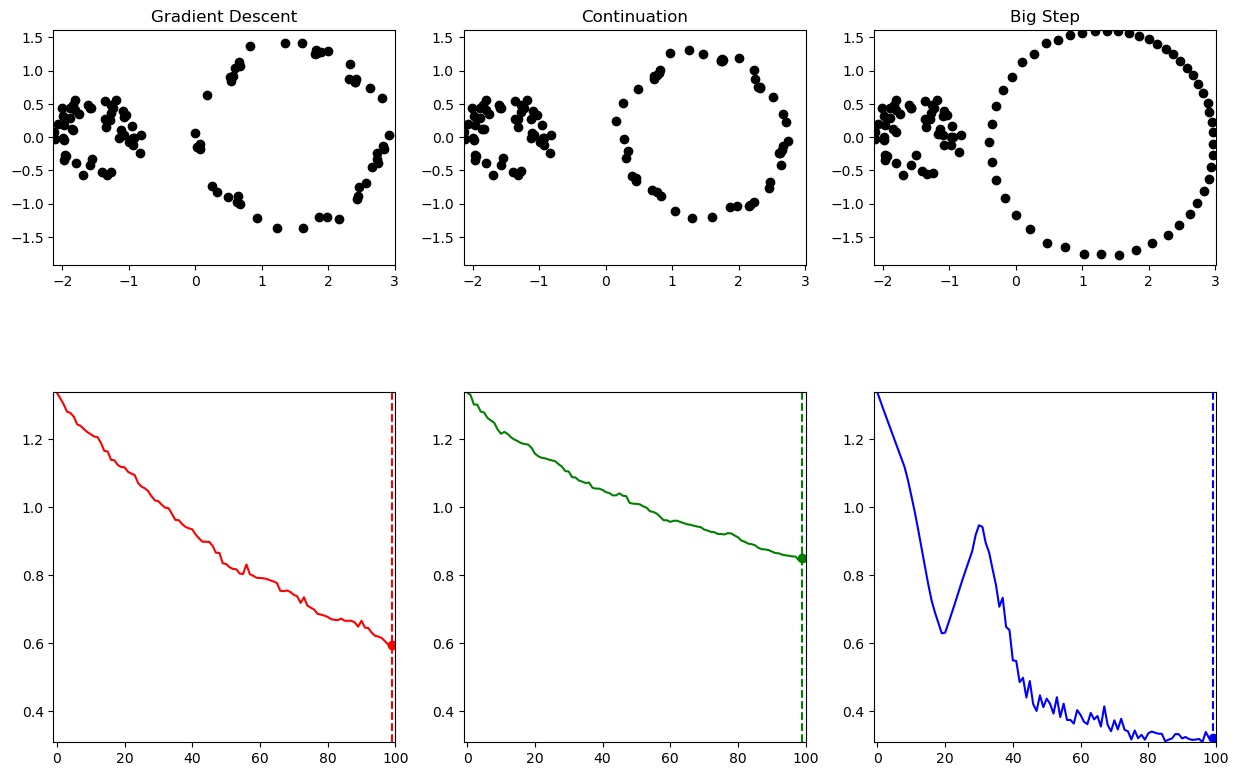

In [10]:
# visualize the result

import matplotlib.animation as animation
import os

title_list = ["Gradient Descent", "Continuation", "Big Step"]
color_list = ["red", "green", "blue"]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
min_loss = min([min(loss) for loss in loss_history_list])
max_loss = max([max(loss) for loss in loss_history_list])
X_history_concat = np.concatenate([np.stack(X_history, axis=0) for X_history in X_history_list], axis=0)
xmin = np.min(X_history_concat[:, :, 0])
xmax = np.max(X_history_concat[:, :, 0])
ymin = np.min(X_history_concat[:, :, 1])
ymax = np.max(X_history_concat[:, :, 1])

def update(i):
    for idx in range(3):
        X_history = X_history_list[idx]
        loss_history = loss_history_list[idx]
        ax1 = axes[0, idx]
        ax2 = axes[1, idx]
        ax1.clear()
        ax2.clear()
        ax1.set_title(title_list[idx])
        ax1.set_xlim(xmin, xmax)
        ax1.set_ylim(ymin, ymax)
        ax1.set_aspect('equal')
        ax1.scatter(X_history[i][:, 0], X_history[i][:, 1], c="black")
        ax2.set_xlim(-1, 100)
        ax2.set_ylim(min_loss-0.001, max_loss+0.001)
        ax2.plot(loss_history, c=color_list[idx])
        ax2.scatter(i, loss_history[i], c=color_list[idx])
        ax2.plot([i, i], [min_loss, max_loss], c=color_list[idx], linestyle="--")

ani = animation.FuncAnimation(fig, update, frames=num_epoch, interval=100)
ani.save("animation.gif", writer="pillow", fps=10)

## How to use `scripts/ph_optimization.py`

The procedure above can be done by running our interface `scripts/ph_optimization.py` 
or calling the function `ph_opt_main` in `scripts/ph_optimization.py`.

To customize `ph_opt_main`, you need to appropriate set the parameters in `OptConfig` class in `scripts/ph_optimization.py`.
For the parameters of `OptConfig`, please refer to `README.md`.

In the following code, we specify the data, the loss and the regularization defined above, 
and perform experiments for multiple `lr` parameters.
(Since it takes a long time to run the code, it is recommended to run the code in the independent python script.
For this reason, we omit the output of the next cell.)

In [11]:
from scripts.ph_optimization import ph_opt_main, OptConfig

method_list = ["gd", "continuation", "bigstep"]
lr_list = [1e-3 * (4**i) for i in range(5)]
num_epoch = 100
##### We commented out the following and run in the other script because it takes a long time to run. #####
for method in method_list:
    for lr in lr_list:
        config = OptConfig(
            exp_name=f"{method}_lr={lr}", 
            save_dirpath=f"../results/sample/from_notebook/{method}_lr{lr}",
            data_func=large_hole_and_small_hole,
            num_trial=5, 
            num_epoch=num_epoch,
            loss_obj=WassersteinLoss(dim_list=[1], desirable_pd=[torch.tensor([[0, 3]])], order=2),
            regularization_obj=CircleRegularization(center=torch.tensor([0, 0]), radius=3),
            method=method, 
            lr=lr, 
            reg_proj=(method=="continuation"), 
        )
        ph_opt_main(config)
        plt.close("all")

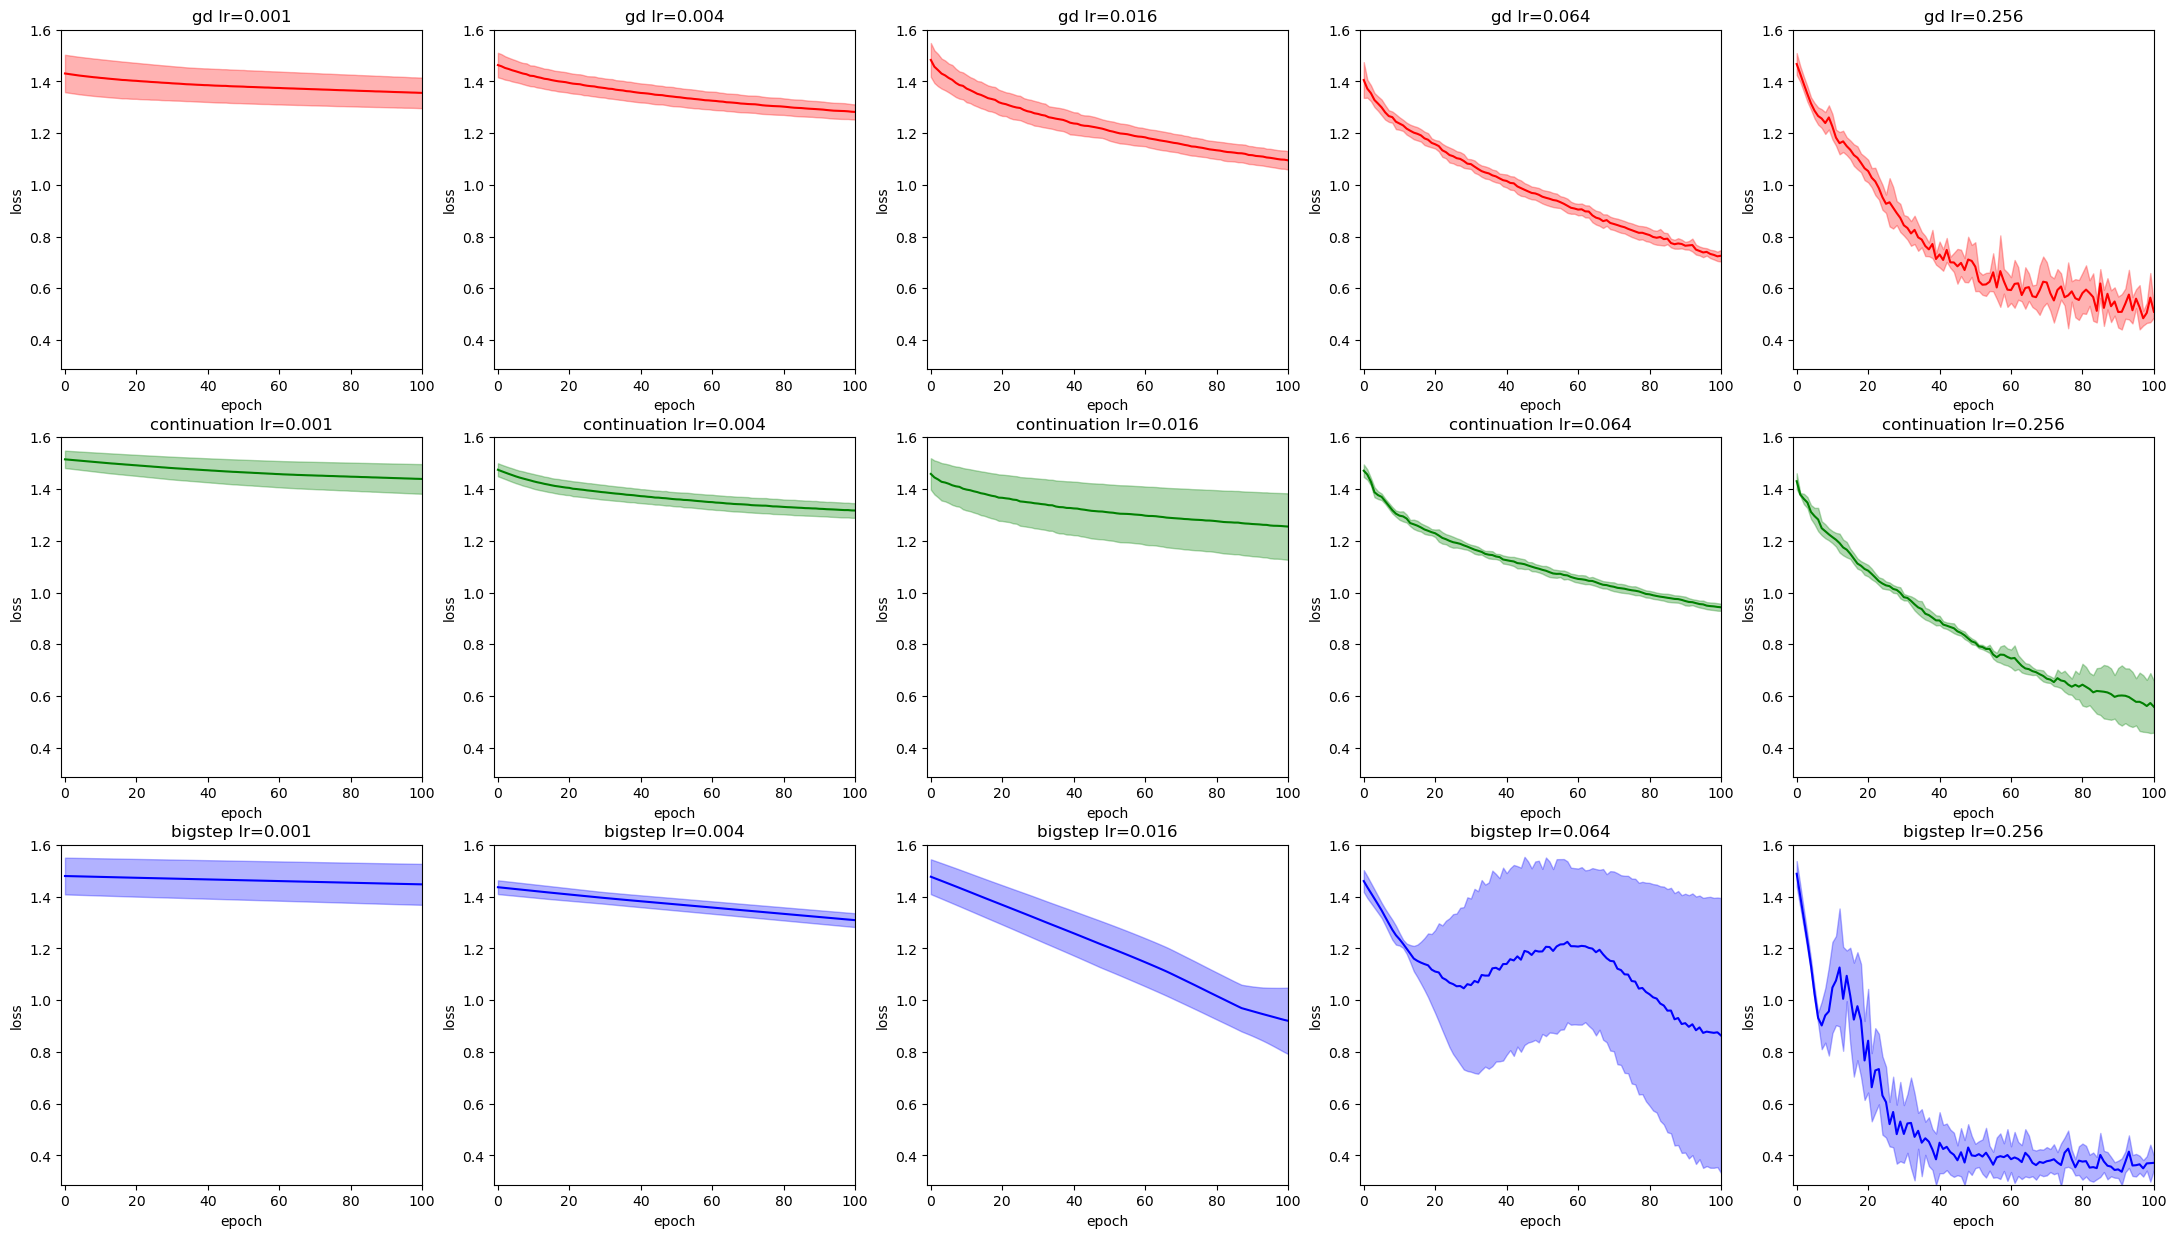

In [13]:
# visualize the result
import pickle

color_list = ["red", "green", "blue"]
loss_history_mean = [[None]*5 for _ in range(3)]
loss_history_std = [[None]*5 for _ in range(3)]
loss_min = 1.6
for i, method in enumerate(method_list):
    for j, lr in enumerate(lr_list):
        with open(f"../results/sample/from_notebook/{method}_lr{lr}/result_dict.pkl", "rb") as f:
            result_dict = pickle.load(f)
        loss_history_list = result_dict["loss_history"]
        loss_history_mat = np.stack(loss_history_list, axis=0) # (num_trial, num_epoch+1)
        loss_history_mean[i][j] = np.mean(loss_history_mat, axis=0)
        loss_history_std[i][j] = np.std(loss_history_mat, axis=0)
        loss_min = min(loss_min, np.min(loss_history_mean[i][j]))

fig, axes = plt.subplots(3, 5, figsize=(27, 15))
for i, method in enumerate(method_list):
    for j, lr in enumerate(lr_list):
        loss_mean = loss_history_mean[i][j]; loss_std = loss_history_std[i][j]
        ax = axes[i, j]
        ax.set_title(f"{method} lr={lr}")
        ax.set_xlim(-1, num_epoch)
        ax.set_ylim(loss_min - 0.05, 1.6)
        ax.plot(loss_mean, c=color_list[i])
        ax.fill_between(np.arange(num_epoch+1), loss_mean-loss_std, loss_mean+loss_std, color=color_list[i], alpha=0.3)
        ax.set_xlabel("epoch"); ax.set_ylabel("loss")

plt.show()

## Continuation as a method to track the point cloud along the path of PD